In [32]:
# Install library
!pip install pytesseract opencv-python
!apt-get install -y tesseract-ocr

# Install the missing dependency library libssl1.1
!wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb

!pip install paddlepaddle==2.5.0
!pip install paddleocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
--2024-10-18 03:55:02--  http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
Resolving archive.ubuntu.com (archive.ubuntu.com)... 91.189.91.81, 91.189.91.82, 185.125.190.82, ...
Connecting to archive.ubuntu.com (archive.ubuntu.com)|91.189.91.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318204 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb.1’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  2.50MB/s    in 0.5s    

2024-10-18 03:55:03 (2.50 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb.1’ saved [1318204/1318204]

(Reading database ... 123686 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2_amd64.deb ...
U

In [33]:
import cv2
import numpy as np
import pytesseract
import time
import re
from matplotlib import pyplot as plt
from google.colab import drive
from paddleocr import PaddleOCR

#Initialize PaddleOCR (using the detection model) 初始化PaddleOCR（使用检测模型）
ocr = PaddleOCR(use_angle_cls=True, lang='en')
# Mount Google Drive to access dataset
drive.mount('/content/drive')


[2024/10/18 03:55:15] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [34]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

#calculate processing time
def timeit(func):
    def wrap(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} 处理时间: {end - start:.4f} 秒")
        return result
    return wrap

#calculate correct rate
def calculate_char_accuracy(recognized_text, correct_text):
    recognized_text = recognized_text.strip().upper()
    correct_text = correct_text.strip().upper()

    match_count = sum(1 for a, b in zip(recognized_text, correct_text) if a == b)
    total_chars = len(correct_text)

    accuracy = (match_count / total_chars) * 100 if total_chars > 0 else 0
    return accuracy

#Load and process images
@timeit
def process_image(image_path):
    #Load image
    img = cv2.imread(image_path)

    #gray
    gray_img = get_grayscale(img)

    #use paddle to detect text areas
    result = ocr.ocr(gray_img, cls=True)

    #show original (Show grayscale images)
    plt.figure(figsize=(10, 10))
    plt.imshow(gray_img, cmap='gray')
    plt.title("灰度化后的图片")
    plt.show()

    #extract the correct answer from the file name
    correct_text = image_path.split("/")[-1].split(".")[0].upper()
    print(f"文件名中提取的正确答案: {correct_text}")

    #initialize accuracy
    total_accuracy_pytesseract = 0  # PyTesseract 识别的正确率
    total_accuracy_paddleocr = 0    # PaddleOCR 识别正确率
    box_count = 0

    #process each text box
    for idx, line in enumerate(result[0]):
        box = line[0]  #The coordinates of the text box 文本框的坐标
        detected_text = line[1][0].strip().upper()  #PaddleOCR predicts the text and converts it to uppercase PaddleOCR 预测的文本，并转换为大写
        detected_text = re.sub(r'\s+', '', detected_text)  #Remove all whitespace characters 去除所有空白字符
        print(f"PaddleOCR 检测到文本: {detected_text}")

        #Extracts and draws a text box 提取并绘制文本框
        box = [list(map(int, point)) for point in box]  #Convert coordinates to integers 将坐标转换为整数
        pts = cv2.polylines(img.copy(), [np.array(box)], isClosed=True, color=(0, 255, 0), thickness=2)

        #Crop text area 裁剪文本区域
        x_min = min([pt[0] for pt in box])
        x_max = max([pt[0] for pt in box])
        y_min = min([pt[1] for pt in box])
        y_max = max([pt[1] for pt in box])
        cropped_img = gray_img[y_min:y_max, x_min:x_max]

        #use PyTesseract recognize character(gray-scale cropping of images) 使用 PyTesseract 进行字符识别（对灰度化的裁剪图像）
        text_recognized = pytesseract.image_to_string(cropped_img).strip().upper()
        text_recognized = re.sub(r'\s+', '', text_recognized)  # 去除所有空白字符
        print(f"清理后的 PyTesseract 识别结果: {text_recognized}")

        #caculate the PaddleOCR correct rate 计算 PaddleOCR 的正确率
        paddle_accuracy = calculate_char_accuracy(detected_text, correct_text)
        print(f"PaddleOCR 字符级正确率: {paddle_accuracy:.2f}%")
        total_accuracy_paddleocr += paddle_accuracy

        #Calculate the correct rate of PyTesseract 计算 PyTesseract 的正确率
        pytesseract_accuracy = calculate_char_accuracy(text_recognized, correct_text)
        print(f"PyTesseract 字符级正确率: {pytesseract_accuracy:.2f}%")
        total_accuracy_pytesseract += pytesseract_accuracy

        box_count += 1

        #Displays cropped text areas 显示裁剪的文本区域
        plt.imshow(cropped_img, cmap='gray')
        plt.title(f"Detected Text: {text_recognized}")
        plt.show()

    #Calculate the average accuracy 计算平均正确率
    avg_accuracy_pytesseract = total_accuracy_pytesseract / box_count if box_count > 0 else 0
    avg_accuracy_paddleocr = total_accuracy_paddleocr / box_count if box_count > 0 else 0

    return avg_accuracy_pytesseract, avg_accuracy_paddleocr

[2024/10/18 04:22:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.04851031303405762
[2024/10/18 04:22:21] ppocr DEBUG: cls num  : 1, elapsed : 0.01819586753845215
[2024/10/18 04:22:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.19866514205932617


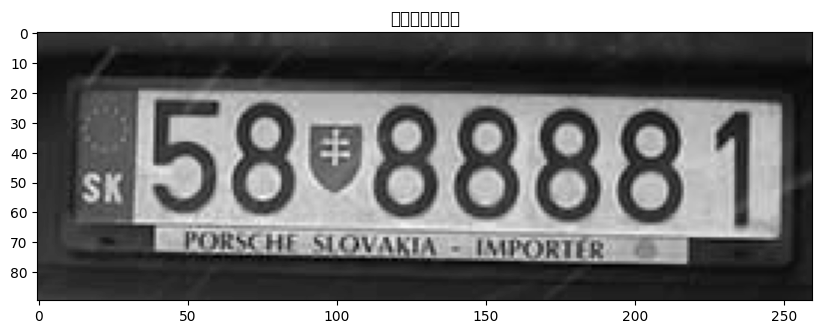

文件名中提取的正确答案: 5888881
PaddleOCR 检测到文本: 5888881
清理后的 PyTesseract 识别结果: 
PaddleOCR 字符级正确率: 100.00%
PyTesseract 字符级正确率: 0.00%


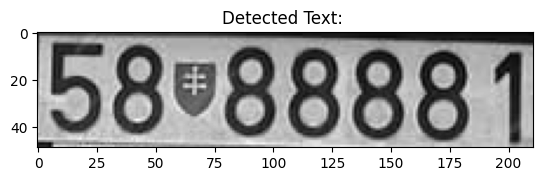

process_image 处理时间: 1.3501 秒
PyTesseract 平均正确率: 0.00%
PaddleOCR 平均正确率: 100.00%


In [36]:
#Main process 主流程
image_path = '/content/drive/My Drive/dataset/5888881.png'

#Process the image and calculate the recognition accuracy rate 处理图像并计算识别的正确率
avg_accuracy_pytesseract, avg_accuracy_paddleocr = process_image(image_path)

#Output average recognition accuracy rate 输出平均识别正确率
print(f"PyTesseract 平均正确率: {avg_accuracy_pytesseract:.2f}%")
print(f"PaddleOCR 平均正确率: {avg_accuracy_paddleocr:.2f}%")